Load and pre process **data**

In [3]:
import os
import zipfile
from google.colab import drive

# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/drive/MyDrive/animals10.zip"  # Training + validation (90%)
holdout_zip_path = "/content/drive/MyDrive/holdout.zip"  # Holdout set (10%)

animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Mounted at /content/drive
✅ Extracted training dataset.
✅ Extracted holdout dataset.
📂 Training Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Holdout Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Check the folder structures

In [4]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Classes in Prediction (Holdout) Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images and apply data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  # ✅ Increased rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!


Plot 5 random images

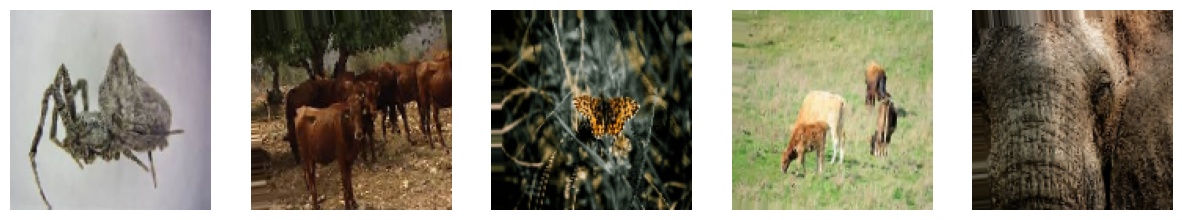

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

Define Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization




# 📌 Step 7: Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(10, activation='softmax')
])

In [23]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=20000, decay_rate=0.95)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Start timer
start_time = time.time()


#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train model with scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,

)


# End timer
end_time = time.time()

# Calculate total training time
training_time = end_time - start_time
print(f"⏱️ Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

model_name = "animal_classifier_v1.keras"  # Custom name
model.save(f"/content/{model_name}")
print(f"✅ Model saved as {model_name}")


Epoch 1/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.8337 - loss: 0.5125 - val_accuracy: 0.7970 - val_loss: 0.6752
Epoch 2/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.8490 - loss: 0.4789 - val_accuracy: 0.8110 - val_loss: 0.6513
Epoch 3/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.8461 - loss: 0.4808 - val_accuracy: 0.8002 - val_loss: 0.6333
Epoch 4/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 101s 171ms/step - accuracy: 0.8424 - loss: 0.4933 - val_accuracy: 0.8167 - val_loss: 0.6072
Epoch 5/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.8464 - loss: 0.4710 - val_accuracy: 0.7696 - val_loss: 0.8074
Epoch 6/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 101s 172ms/step - accuracy: 0.8502 - loss: 0.4559 - val_accuracy: 0.8046 - val_loss: 0.6683
Epoch 7/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 172ms/step - accuracy: 0.8548 - loss: 0.4464 - val_accuracy: 0.8218 - val_loss: 0.6148
Epoch 8/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 101s 172ms/step - accuracy: 0.8524 -

# Evaluate Model Performance on Validation Set (NOT on Holdout)

148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.8100 - loss: 0.6915
Validation Accuracy: 81.63%
Validation Loss: 0.6576
Training Accuracy: 89.19%
Training Loss: 0.3420


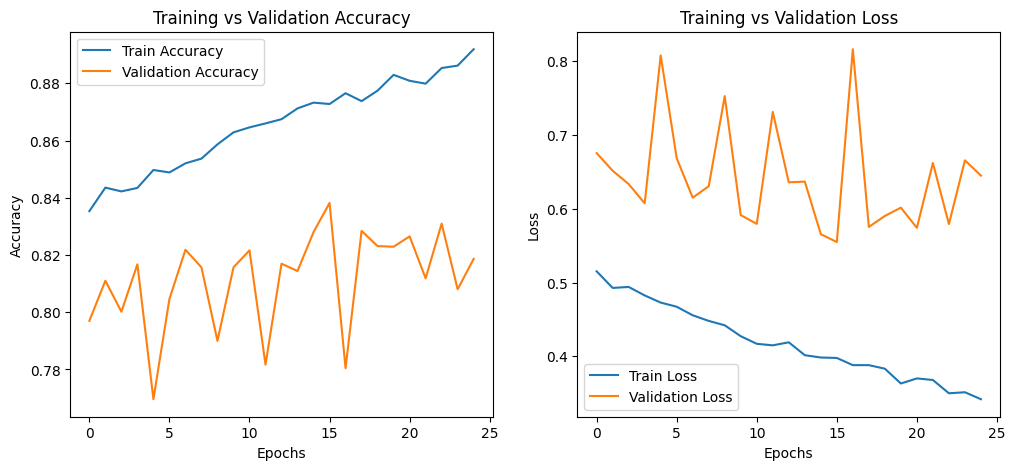

In [25]:
# 📌 Step 10: Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# 📌 Step 11: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

In [ ]:
#Compute and report metrics such as  precision, recall, and F1-score.

Predict on validation set

In [27]:
import numpy as np

# Get true labels and predicted labels
y_true = []
y_pred = []

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    predictions = model.predict(images)  # Get predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(np.argmax(predictions, axis=1))  # Get highest probability class

    if len(y_true) >= val_generator.samples:  # Stop when all validation images are processed
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

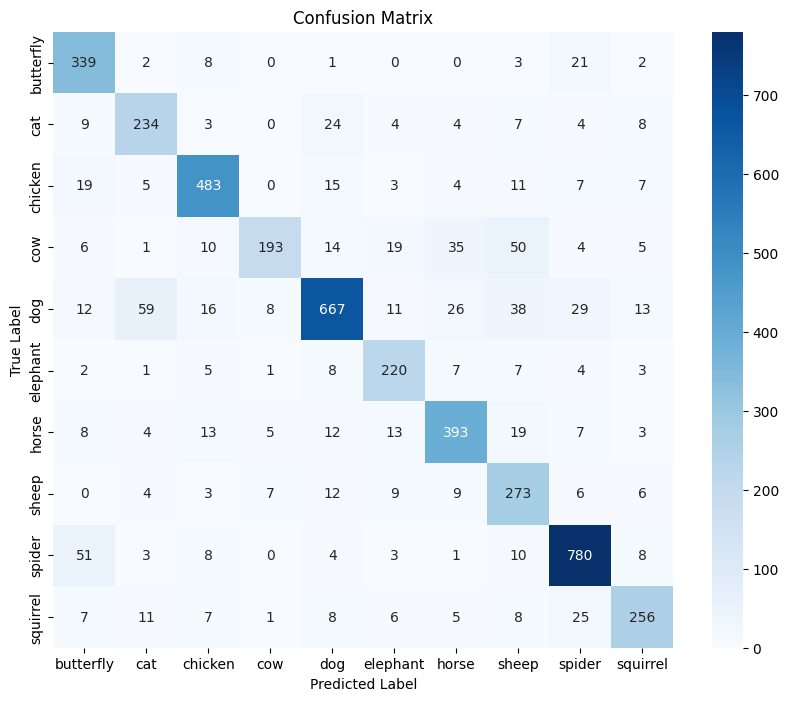

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Predict on Holdout Set (No Evaluation, Only Predictions)


✅ Making Predictions on Holdout Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━

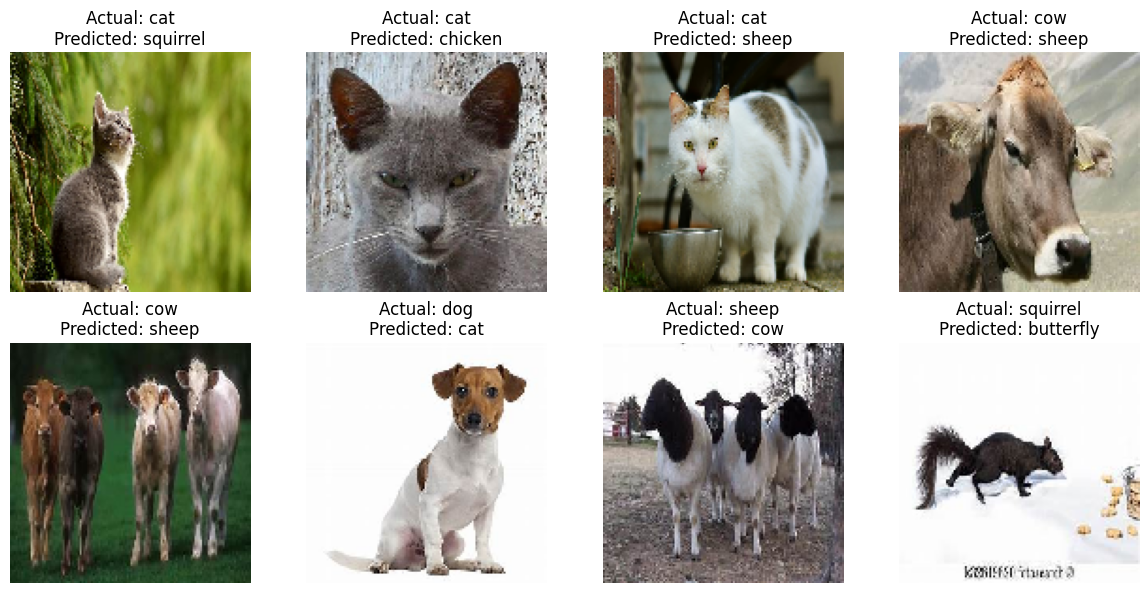

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

class_labels = list(train_generator.class_indices.keys())

misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files[:5]:  # Predict on first 5 images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if misclassified
                if predicted_label != class_name:
                    misclassified_images.append((img_path, class_name, predicted_label))

# 📌 Step 2: Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
